# 3. MORDM OPTIMIZATION

## 3.1 Worst-case reference scenarios

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Constraint, Policy, Scenario)

from problem_formulation import get_model_for_problem_formulation

import time

In [2]:
# load the basecase results
experiments, outcomes = load_results('../results/basecase_results.tar.gz') 
outcomes_df = pd.DataFrame.from_dict(outcomes)

In [3]:
# load the Series which defines which are the experiments within the established threshold in the first part
y3 = pd.read_csv('../results/boolean_worst_scenarios.csv').iloc[:, 1:]

# Convert Series to a list
y = np.array(y3).squeeze()

In [4]:
# Filter out experiments which obey the established threshold
experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

In [5]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [6]:
# Aggregate the outcome values
df_agg_t, df_agg_tl = aggregate_df(outcomes_df)

In the next step we want to select the worst case scnearios in order to optimize over them. For this, we rank all the different columns in the outcomes dataframe from highesto to lowest value. Then, we sum up the rank number and chose the scenarios which have the highest rank, i.e. the ones that perform the worst.

In [7]:
# Given that we're ranking on the base case, the dike investment costs are zero. Therfore, we drop those columns
dike_inv = ['A.1_Dike Investment Costs time aggregate', 'A.2_Dike Investment Costs time aggregate', 
            'A.3_Dike Investment Costs time aggregate', 'A.4_Dike Investment Costs time aggregate', 'A.5_Dike Investment Costs time aggregate']

df_agg_t.drop(columns=dike_inv, inplace=True)

In [8]:
# We rank each column and sum over each row value to obtain the rank of each scenario for Expected annual damage and expected number of deaths
rank_df = pd.DataFrame()
for column in df_agg_t.columns:
    rank_df[column] = df_agg_t[column].rank()

rank_df['Final rank'] = rank_df.sum(axis=1)

In [9]:
# In order to sort out the values for the top 5 worst scenarios, we retrieve their index to then filter them out from the experiments 
worst_5_df = rank_df.sort_values(by='Final rank',ascending=False).head()
worst_5_ind = list(worst_5_df.index)

# Finally, we filter the worst scenarios out and only get back the first 19 columns, which correspond to the uncertainty values in each scenario
scenarios_df = experiments_of_interest.iloc[worst_5_ind,:19]
indexes_scenarios = scenarios_df.index.to_list()
indexes_scenarios

[3794, 2761, 1322, 4347, 1009]

# 2. Multi-Scenario MORDM

Now that we have the values of the uncertainties that correspond to the top 5 worst case scenarios, we specify them in the workbench and perform Multi-Scenario MORDM. ...

In [10]:
# Specify the scenarios in the workbench
scenarios = [Scenario(f"{index}", **row) for index, row in scenarios_df.iterrows()]

In [11]:
# Import the maximum and minimum values found across performing experiments for 100 policies across 400 scenarios
import pickle
with open('../results/min_max_range_basecase.pickle', 'rb') as f:
    max_range_bc, min_range_bc = pickle.load(f)
with open('../results/min_max_range_randompolicies.pickle', 'rb') as f:
    max_range_rp, min_range_rp = pickle.load(f)

In [12]:
max_range = pd.concat([max_range_bc, max_range_rp], axis=1)
min_range = pd.concat([min_range_bc, min_range_rp], axis=1)

In [13]:
max_range = max_range.max(axis=1)
min_range = min_range.min(axis=1)
max_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)
min_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)

In [14]:
max_range

Expected Annual Damage time location aggregate       6.790428e+09
Dike Investment Costs time location aggregate        9.334020e+08
Expected Number of Deaths time location aggregate    5.855678e+00
Expected Evacuation Costs time aggregate             1.246373e+05
dtype: float64

In [15]:
## WE DONT NEED THE EVACUATION COSTS ANY MORE

In [16]:
from problem_formulation_altered import get_model_for_problem_formulation_altered

In [17]:
# Initialise the altered formulation
dike_model, planning_steps = get_model_for_problem_formulation_altered(min_range,max_range)

deaths = ['Expected Number of Deaths']

max_num_deaths = 0.0001 * 3 * 5


# MENTION THAT WE DONT ADD THIS?
# Adding the constraint for Room for the total number of deaths.
constraints = [Constraint("Max number of deaths", outcome_names=deaths,
                          function=lambda x:max(0, x-max_num_deaths))]


In [18]:
# perform the analysis


ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 7500
results_deep = []
convergence_all = []


# # #epsilons=[1e7, 1e6, 1e3, 0.01]

# #We define the epsilons as a 100th part of the maximum value of the outcome
# for scenario in scenarios:
#     with MultiprocessingEvaluator(dike_model) as evaluator:
#         results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
#                                         epsilons=[1e7, 1e6, 0.00001],
#                                         convergence=convergence_metrics, reference=scenario, constraints=constraints)
                                        
        
#         results_deep.append(results_runs)
#         convergence_all.append(convergence)

In [19]:
# from ema_workbench import save_results

# for i in range(len(results_deep)):
#     save_results((results_deep[i], convergence_all[i]), f'../results/mordm_7500_rp_scenario{i}.tar.gz')

In [20]:
from ema_workbench import load_results

results_deep = []
convergence_all = []

for i in range(5):
    result, convergence = load_results(f'../results/mordm_7500_rp_scenario{i}.tar.gz')
    results_deep.append(result)
    convergence_all.append(convergence)

[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_7500_rp_scenario0.tar.gz
[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_7500_rp_scenario1.tar.gz
[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_7500_rp_scenario2.tar.gz
[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_7500_rp_scenario3.tar.gz
[MainProcess/INFO] results loaded succesfully from D:\Willy\Documents\GitHub\Model_based_decision_making\EPA1361\final assignment\results\mordm_7500_rp_scenario4.tar.gz


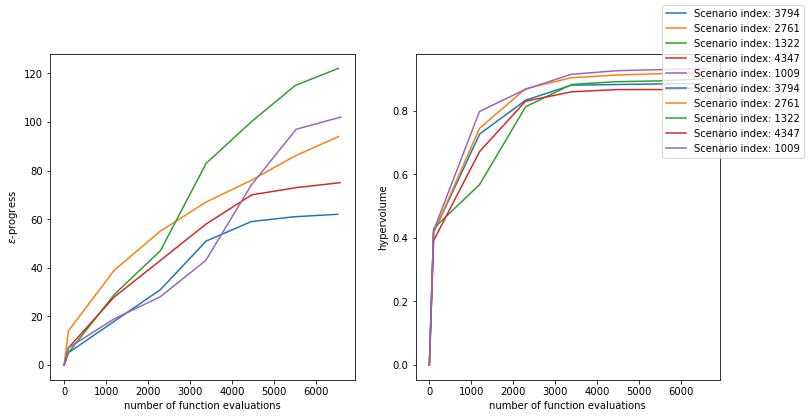

In [21]:

# plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, con in enumerate(convergence_all):
    ax1.plot(con['nfe'], con['epsilon_progress'], label=f'Scenario index: {indexes_scenarios[i]}')
    ax2.plot(con['nfe'], con['hypervolume'], label=f'Scenario index: {indexes_scenarios[i]}')

ax1.set_ylabel('$\epsilon$-progress')
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.legend()
plt.show()

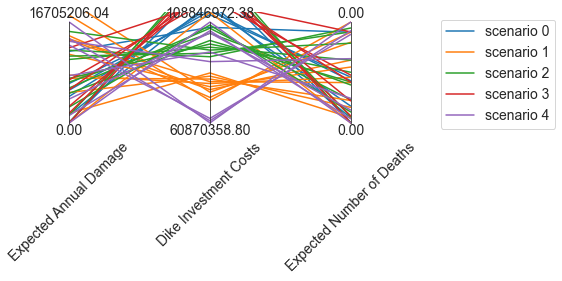

In [22]:
from ema_workbench.analysis import parcoords


colors = iter(sns.color_palette())

data = results_deep[4].iloc[:, -3:]
limits = parcoords.get_limits(data)

# limits.loc[0, ['inertia', 'reliability']] = 1
# limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
# limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
# limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits, rot=45)


for i, result in enumerate(results_deep):
    color = next(colors)
    data = result.iloc[:, -3:]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()
